this script calculate the publication reduction of countries and visualize the results.the input of the script is:
- raw_path: number of publication of countries in each year and discipline assigned by full counting
- filter_path: publication record after removing based on specific rules (e.g. removing funding-exchange pub).
- geopath: shp file for world map plot
- region_path: country-region information

The output of the script is:
- the worldmap with countries colored by the proportion of reduction
- the aggregated boxplot with same result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import funding.core
import seaborn as sns

In [2]:
cntry_full_path="../../data/nf_folder/Data/DerivedData/Derived/cntry_author_full.csv"
cntry_filter_path='../../data/nf_folder/Data/DerivedData/Derived/dep-FundInternational/pub_noInt_fund.csv'
geopath="../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

plot_path="/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/dep-FundInternational/pub_reduction_global.pdf"

In [3]:
# Parameters
cntry_full_path = "../data/NationalFunding/Data/simulated_data/Data/DerivedData/Derived/cntry_author_full.csv"
cntry_filter_path = "../data/NationalFunding/Data/simulated_data/Data/DerivedData/Derived/dependence/pub_no_exclusive_int_fund.csv"
geopath = "../data/NationalFunding/Data/simulated_data/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"
region_path = (
    "../data/NationalFunding/Data/simulated_data/Data/AdditionalData/cntry_region.xlsx"
)
plot_path = "../data/NationalFunding/Data/simulated_data/Figs/Figs/dependence_NoForeignFund/pub_reduction_no_exclusive_foreign_global.pdf"


In [4]:
raw_df=pd.read_csv(cntry_full_path)
raw_df.head()

,cntry,year,dis,count
0,Afghanistan,2009,9,1
1,Afghanistan,2009,23,1
2,Afghanistan,2010,69,1
3,Afghanistan,2010,78,1
4,Afghanistan,2010,82,1


In [5]:
filter_df=pd.read_csv(cntry_filter_path)
filter_df.head()

,cntry,year,dis,count
0,Afghanistan,2011,41,1
1,Afghanistan,2011,42,1
2,Afghanistan,2012,51,1
3,Afghanistan,2017,28,1
4,Albania,2009,31,1


In [6]:
cnt=raw_df.merge(filter_df,on=['cntry','year','dis'],suffixes=('_raw', '_filter'),how='left')
cnt=cnt.fillna(0)
cnt=cnt.groupby(['cntry']).agg({'count_raw':'sum',
                              'count_filter':'sum'})

In [7]:
cnt['prop']=(cnt['count_raw']-cnt['count_filter'])/(cnt['count_raw'])

In [8]:
test = cnt.reset_index()
test[test.cntry.isin(['United States','France','Germany','United Kingdom'])]

,cntry,count_raw,count_filter,prop
59,France,32628,13365.0,0.590382
65,Germany,45414,20202.0,0.555159
187,United Kingdom,46751,20032.0,0.571517
188,United States,148756,95771.0,0.356187


In [9]:
region_df=pd.read_excel(region_path)[['cntry','region2']].drop_duplicates()
region_df=region_df.replace(to_replace={'region2':{'EU':'Europe','Other Europe':'Europe'}})
region_df.head()

,cntry,region2
0,Algeria,Africa
1,Angola,Africa
2,Belgian Congo,Africa
3,Benin,Africa
4,Botswana,Africa


In [10]:
cnt=cnt.reset_index().merge(region_df,on='cntry',how='left')
cnt=cnt.dropna() #drop antarctica

In [11]:
world_geo=funding.core.read_geofile(geopath)
world_geo.head(2)

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."


In [12]:
cnt[cnt.cntry=='United States']

,cntry,count_raw,count_filter,prop,region2
188,United States,148756,95771.0,0.356187,North America


In [13]:
cnt.sort_values(by='prop').head(20)

,cntry,count_raw,count_filter,prop,region2
109,Marshall Islands,1,1.0,0.000000,Oceania
5,Antigua & Barbuda,1,1.0,0.000000,North America
37,China,111340,89578.0,0.195455,Asia
192,Vatican,7,5.0,0.285714,Europe
188,United States,148756,95771.0,0.356187,North America
183,Turkmenistan,8,5.0,0.375000,Asia
159,Solomon Islands,8,5.0,0.375000,Oceania
74,Haiti,16,10.0,0.375000,North America
178,Togo,37,21.0,0.432432,Africa
71,Guinea,17,9.0,0.470588,Africa


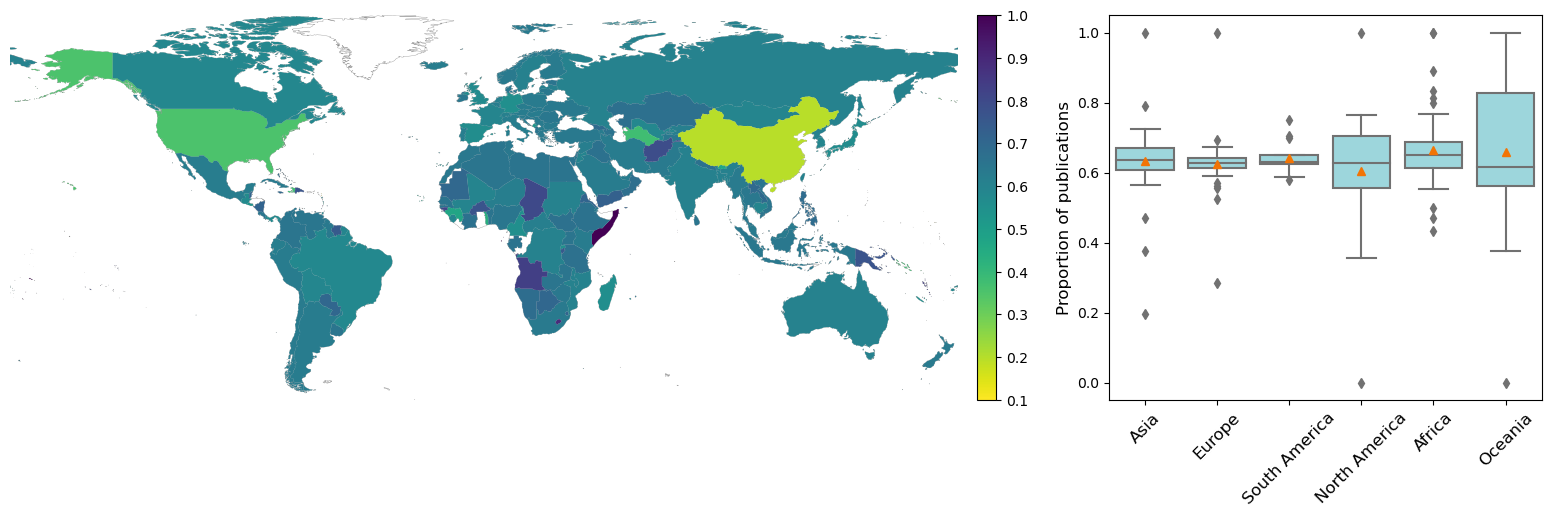

In [14]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.15},figsize=(20,5))
plot_data=world_geo.merge(cnt[['cntry','prop']],left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
funding.core.plot_worldmap(ax[0], fig, world_geo, plot_data, 'prop','viridis_r',0.1,1)
ax[0].margins(0)

orders=['Asia','Europe','South America','North America','Africa','Oceania']
sns.boxplot(x='region2',y='prop',data=cnt,color='#92DFE6',
            order=orders,ax=ax[1],showmeans=True,meanprops={"markerfacecolor":"#F27405", "markeredgecolor":"#F27405"})
ax[1].set_ylabel('Proportion of publications',fontsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(orders,rotation=45,fontsize=12)
plt.savefig(plot_path,bbox_inches='tight')